# 11 - Building & Training Convolutional Neural Network
## Feature Building
In the last post, I looked at loading and resizing images within cv2, an image processing library in python. In this post, I'm going to aggregate all the photos of me and my girlfriend and create an input feature array to pass into our TFlearn model. Let's get it.

All my photos are stored on my s3 repository. I'm going to use boto to get all the photos into a multidimensional array. When I was looking at the MNIST stuff, I had an array of something like [10000, 28, 28, 1], or
- 10 thousand images
- 28 rows
- 28 columns
- 1 pixel

I'm going to try to replicate this format.

In [99]:
import cv2
import numpy as np
import pandas as pd
import urllib
import math
import boto3
import os
import copy
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Connect to s3 bucket
s3 = boto3.resource('s3', region_name = 'ca-central-1')
my_bucket = s3.Bucket('2017edmfasatb')

In [3]:
# Get all files in the project directory under chi_lars_face_detection/photos/
chi_photos = [i.key for i in my_bucket.objects.all() if 'chi_lars_face_detection/photos/chi/' in i.key]
lars_photos = [i.key for i in my_bucket.objects.all() if 'chi_lars_face_detection/photos/lars/' in i.key]

In [4]:
print('There are {} photos of Chi and {} photos of Lars'.format(len(chi_photos), len(lars_photos)))

There are 203 photos of Chi and 200 photos of Lars


Doing some really quick math, we will have

$$181\ Pixel\ Rows\times 181\ Pixel\ Columns=32,761\ Pixels\ Per\ Photos$$

This gives us

$$32,761\ Pixels\times 403\ Photos=13.2M\ Pixels$$

which is good for

$$13.2M\ Pixels\times 8\ Bits\ Per\ Pixel\approx106Mb$$

That's just the top of my head calculation to get a sense of how big the data set is. For reference, the MNIST dataset comes out to

$$28\ Pixel\ Rows\times 28\ Pixel\ Columns\times 65,000\ Photos\times 8\ Bits\approx408Mb$$

My data set, while _**significantly less training samples (400 vs 65,000)**_, is actually already a quarter of the size of the MNIST data set. Good to know for reference. We'll be convoluting these down before we enter them into our NN anyways, but that convolution still takes some time depending on image size too.

I might have to think a bit about how I want the convolution and max pooling to be done as well. The convolution portion of the MNIST tutorial from sentdex went down like this:
- 28 x 28 input
- 2D convolutional layer with 32 filters of size 2 x 2
- 2D max pooling on 2 x 2 windows
- 2d convolutional layer with 64 filters of size 2 x 2
- 2D max pooling on 2 x 2 windows

We have to think about what the convolutional filters are doing here... The convolutional filters are trying to find _**patterns**_ in the image:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/15_finished_convolution_3_filters.png" style="width: 500px;"/>

My first instinct is that I need my convolutional filter to actually be large enough to represent some part of the image, and small enough to zone in on a specific part of the image. My first instinct is to maybe take something that can represent part of my ear / mouth / eye / nose... Maybe something like this:

In [5]:
# Define function to convert URL to numpy array
def url_to_image(url):
    # Download the image, convert it to a numpy array, and then read it into OpenCV format
    resp = urllib.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
    
    # Rotate image
    image = np.rot90(image, 3)
    
    # Build resize into function
    image = cv2.resize(image, (0,0), fx=0.06, fy=0.06)

    # Return the image
    return image

In [6]:
# Load image from URL on S3
img_chi = url_to_image('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/photos/chi/IMG_1265.JPG')

In [7]:
# Draw rectangle
img_chi = cv2.rectangle(
    img_chi, 
    (130, 90),      # Top left vertex of rectangle
    (140, 100),     # Bottom right vertex of rectangle
    (0, 0, 0),      # BGR color of rectangle
    1               # Pixel width of rectangle lines
)

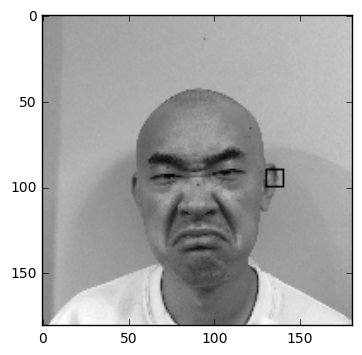

In [8]:
# Show image in matplotlib
plt.imshow(img_chi, cmap='gray')

To me, that seems like a decent filter size... But we have to remember that _**I don't know Jack**_.

<img src="https://gamefaqs.akamaized.net/box/1/2/3/9123_front.jpg" style="width: 300px;"/>

That, my friend, is what I call a throwback haha. But yeah I really don't know if this is the right choice, but let's try trial by fire. I'll start with a filter size of 10 x 10 pixels (represented by the rectangle above, but I also need to think about how many filters I need. For the MNIST dataset, we used 32 and then 64 filters. The image itself is only 28 x 28, so we had roughly the same number of filters as there is width / height pixels of the image, and then double that. By that logic, maybe I should try... 200 and 400? I really don't quite understand the impact of these numbers on performance yet.

In the max pooling steps, we are reducing the size of our convoluted layers by summarizing a window of pixels with a single pixel. In the MNIST tutorial, we used a 2 x 2 window for max pooling, so our 4-pixel window gets summarized by 1 pixel, so our image becomes 4 times smaller... from 181 x 181 down to ~90 x 90. This gets convoluted and max pooled again down to ~45 x 45 in the second convolutional layer. Anyways, I think that's how it will work. I'm going to make it a point to see if I can explore the results of the first and second convolutional layer. I"m really not sure if I'll be able to, but it would be pretty cool and would add a lot to my understanding.

Without further ado, let's get these photos into an array.

In [9]:
# Loop through all files to download into a single array from AWS
url_prefix = 'https://s3.ca-central-1.amazonaws.com/2017edmfasatb'

In [10]:
# Trying out the new tqdm library for progress bar
chi_photos_list = [url_to_image(os.path.join(url_prefix, x)) for x in tqdm(chi_photos)]

100%|██████████| 203/203 [04:18<00:00,  1.37s/it]


Nice! It looks like if we wrap our iterating object around the _**[tqdm](https://pypi.python.org/pypi/tqdm)**_ function, we get an animated toolbar that tells us which iteration is currently being processed, how long each iteration is taking, and how long all the iterations are expected to take.

At the end of the day, it took around 4 minutes to pull all the photos of me, but this includes the rotating and resizing of the photos as well (although I'm sure that's not _**too much**_ overhead).

In [11]:
# Trying out the new tqdm library for progress bar
lars_photos_list = [url_to_image(os.path.join(url_prefix, x)) for x in tqdm(lars_photos)]

100%|██████████| 200/200 [04:41<00:00,  1.39s/it]


In [19]:
# Convert to numpy arrays
chi_photos_np = np.array(chi_photos_list)
lars_photos_np = np.array(lars_photos_list)

In [20]:
# View shape of numpy array
chi_photos_np.shape

(203, 181, 181)

It looks like we've got 3 dimensions in our numpy... We had 4 dimensions in our MNIST data array unfortunately. The dimensions should look something like $[203, 181, 181, 1]$, I guess every every individual element of the array needs to... well be it's own array. An array of one single number. Looking back at the MNIST tutorial now, it seems that the data is also _**scaled**_ between 0 and 1, which I assume represents 0 and 255... Boy, I have a decent amount of cleaning to do.

## Scaling Inputs
Let's tackle the scaling first. Sklearn has a scaler that can be easily used to transform the data. We are working with 2D arrays here, however, so I might have to define the scaling limits manually and scale the images as they're coming in in my **url_to_image** function.

In [26]:
# Review image shape
print('Image shape is: {}'.format(img_chi.shape))

# Review image values
print(img_chi[:50, :50])

Image shape is: (181, 181)
[[140 139 145 ..., 158 162 160]
 [137 142 140 ..., 158 161 159]
 [140 140 139 ..., 159 160 159]
 ..., 
 [144 144 151 ..., 164 162 166]
 [144 143 146 ..., 166 165 164]
 [145 146 145 ..., 165 165 168]]


In [27]:
# Try out scaler on a manually set data (min of 0, max of 255)
from sklearn.preprocessing import MinMaxScaler

In [35]:
# Set test data list to train on (min of 0, max of 255)
test_list = np.array([0, 255]).reshape(-1, 1)
test_list

array([[  0],
       [255]])

In [36]:
# Initialize scaler
scaler = MinMaxScaler()

In [37]:
# Fit test list
scaler.fit(test_list)

/Users/chiwang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [39]:
scaler.transform(np.array([0, 10, 100, 200, 255]).reshape(-1, 1))

array([[ 0.        ],
       [ 0.03921569],
       [ 0.39215686],
       [ 0.78431373],
       [ 1.        ]])

It looks like it's doing well. I have my scaler in hand.

## Reshaping 3D Array To 4D Array
Revisiting my problem before - How do I get my $[203, 181, 181]$ array to a $[203, 181, 181, 1]$ shape? Well, actually, I think sklearn has actually answered that question for me with a warning message haha. In the last section, when I created my test list, I used:

~~~~
test_list = np.array([0, 255]).reshape(-1, 1)
~~~~

That _**reshape(-1, 1)**_ part somehow made all my elements into singular arrays. So, by [this post](https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape), the _**-1**_ parameter for _**reshape**_ means an "undisclosed" dimension.

We tested with a $[1, 2]$ array (one row, two columns). By reshaping to (-1, 1), we are saying
1. We first want to ensure that there is only one column
2. We then don't care about the number of rows in the resulting array as long as we have one column (the _**-1 parameter**_)

We now have a $[2, 1]$ array as a result. It looks like the reshape command is what I need here. Let's try it on the array with my photos.

In [40]:
chi_photos_np.reshape(-1, 181, 181, 1).shape

(203, 181, 181, 1)

Nice! I've done it! It was easier than I had ever imaged. Definitely have to remember reshape for future uses.

## Putting It All Together
Let's try to reshape and scale the inputs. I think the sklearn scalers take in a 1 dimensional array, so maybe I can use reshape to get the data ready there as well!

In [46]:
# Reshape to prepare for scaler
chi_photos_np_flat = chi_photos_np.reshape(1, -1)
chi_photos_np_flat[:10]

array([[139, 136, 136, ..., 141, 140, 138]], dtype=uint8)

In [47]:
# Scale
chi_photos_np_scaled = scaler.transform(chi_photos_np_flat)
chi_photos_np_scaled[:10]

array([[ 0.54509804,  0.53333333,  0.53333333, ...,  0.55294118,
         0.54901961,  0.54117647]])

Beauty! Let's do this for Lars' photos as well.

In [48]:
# Reshape to prepare for scaler
lars_photos_np_flat = lars_photos_np.reshape(1, -1)
lars_photos_np_scaled = scaler.transform(lars_photos_np_flat)

Now let's reshape.

In [49]:
# Reshape
chi_photos_reshaped = chi_photos_np_scaled.reshape(-1, 181, 181, 1)
lars_photos_reshaped = lars_photos_np_scaled.reshape(-1, 181, 181, 1)

print('{} has shape: {}'. format('chi_photos_reshaped', chi_photos_reshaped.shape))
print('{} has shape: {}'. format('lars_photos_reshaped', lars_photos_reshaped.shape))

chi_photos_reshaped has shape: (203, 181, 181, 1)
lars_photos_reshaped has shape: (200, 181, 181, 1)


I can't really check to see if the photos are back in their original form because the RGB values are off now... I'll have to assume that the reshape put everything back togehter in its original place.

My final step is just to concatenate these two Chi / Lars arrays into a single x_input array.

In [80]:
# Create copy of chi's photos to start populating x_input
x_input = copy.deepcopy(chi_photos_reshaped)

print('{} has shape: {}'. format('x_input', x_input.shape))

x_input has shape: (203, 181, 181, 1)


In [81]:
# Concatentate lars' photos to existing x_input
x_input = np.append(x_input, lars_photos_reshaped, axis = 0)

print('{} has shape: {}'. format('x_input', x_input.shape))

x_input has shape: (403, 181, 181, 1)


I think I'm finally ready to train! Oh wait... I haven't prepared the labels.

## Preparing Labels
In the MNIST data set, the labels were one hot encoded, so here, basically the label will be the array $[1, 0]$ when the photo is of me, and $[0, 1]$ when the photo is of my girlfriend. Easy enough.

In [112]:
# Create label arrays
y_chi = np.array([[1, 0] for i in chi_photos_reshaped])
y_lars = np.array([[0, 1] for i in lars_photos_reshaped])

print('{} has shape: {}'. format('y_chi', y_chi.shape))
print('{} has shape: {}'. format('y_lars', y_lars.shape))

y_chi has shape: (203, 2)
y_lars has shape: (200, 2)


In [113]:
# Preview the first few elements
y_chi[:5]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

In [114]:
y_lars[:5]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

Let's concatenate these two into one array as well.

In [115]:
# Create copy of chi's labels to start populating y_input
y_input = copy.deepcopy(y_chi)

print('{} has shape: {}'. format('y_input', y_input.shape))

y_input has shape: (203, 2)


In [116]:
# Concatentate lars' labels to existing y_input
y_input = np.append(y_input, y_lars, axis = 0)

print('{} has shape: {}'. format('y_input', y_input.shape))

y_input has shape: (403, 2)


Ok... NOW I think I'm ready to train...

## Training
I'm going to just copy and paste the CNN structure I used for the MNIST tutorial and see what happens. I'm running this on my own laptop by the way, let's observe the speed.

In [83]:
# TFlearn libraries
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tflearn.datasets.mnist as mnist

In [84]:
# sentdex's code to build the neural net using tflearn
#   Input layer --> conv layer w/ max pooling --> conv layer w/ max pooling --> fully connected layer --> output layer
convnet = input_data(shape = [None, 181, 181, 1], name = 'input')

convnet = conv_2d(convnet, 200, 10, activation = 'relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 400, 10, activation = 'relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 10, activation = 'softmax')
convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.01, loss = 'categorical_crossentropy', name = 'targets')

### Train Test Split
I'm just going to do a 90 / 10 train test split here
- My training data will consist of roughly 360 training images
- My test data will consist of roughly 40 test images

In [87]:
# Import library
from sklearn.cross_validation import train_test_split

In [119]:
print(x_input.shape)
print(y_input.shape)

(403, 181, 181, 1)
(403, 2)


In [120]:
# Perform train test split
x_train, x_test, y_train, y_test = train_test_split(x_input, y_input, test_size = 0.1, stratify = y_input)

### Training
Let's try training with 1 epoch.

In [ ]:
# Train with data
model = tflearn.DNN(convnet)
model.fit(
    {'input': x_train},
    {'targets': y_train},
    n_epoch = 1,
    validation_set = ({'input': x_test}, {'targets': y_test}),
    snapshot_step = 500,
    show_metric = True
)

--- 5 seconds later ---

<span style="color:red; font-size: 3em;">**Welp, that crashed my laptop**</span>

My computer just froze up and I had to restart. This is one of those times I need to turn on my AWS batsignal. I'm going to create another copy of this notebook and run it on AWS. I'll use that as my next post.